## VQA Attention Heatmap Extraction for Visual Curiosity Engine

This notebook extracts attention heatmaps from VQA (Visual Question Answering) models to identify question-relevant regions in images.

**Goal**: Extract attention maps showing which image regions VQA models focus on when answering questions, and integrate these with your curiosity heatmaps.

### Applications:
1. **Question-driven curiosity**: Regions important for answering questions may also provoke questions
2. **Validation**: Compare VQA attention with your curiosity annotations
3. **Hybrid heatmaps**: Combine VQA attention with Gaussian + Saliency for richer curiosity prediction
4. **Analysis**: Understand which regions are question-relevant vs visually salient


In [1]:
# Install required packages
%pip install transformers torch torchvision pillow opencv-python matplotlib numpy scikit-image


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import json
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import BlipProcessor, BlipForQuestionAnswering
import warnings
warnings.filterwarnings('ignore')

print("Imports loaded")


c:\Users\tanma\Documents\VC_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports loaded


In [3]:
# Robust JSON loader (handles different encodings)
def load_json_any_encoding(path):
    """Load JSON file with multiple encoding attempts"""
    encodings = ['utf-8', 'utf-8-sig', 'utf-16', 'utf-16-le', 'utf-16-be',
                 'utf-32', 'utf-32-le', 'utf-32-be', 'cp1252', 'latin1']
    raw = Path(path).read_bytes()
    for enc in encodings:
        try:
            return json.loads(raw.decode(enc))
        except Exception:
            continue
    raise ValueError(f'Failed to decode JSON: {path}')

# Load annotations for a specific image
def load_image_annotation(domain_dir, img_name):
    """Load annotation for a specific image"""
    ann_path = Path(domain_dir) / 'annotations.json'
    if not ann_path.exists():
        return None
    
    try:
        data = load_json_any_encoding(str(ann_path))
        key = 'annotations' if 'annotations' in data else ('images' if 'images' in data else None)
        if key is None:
            return None
        
        for item in data[key]:
            if item['name'] == img_name:
                return item
        return None
    except Exception as e:
        print(f"Error loading {ann_path}: {e}")
        return None

# Load all annotations (for batch processing)
def load_all_annotations():
    """Load all annotations from Domain_1 through Domain_5"""
    all_data = []
    domains = [f"Domain_{i}_Images" for i in range(1, 6)]
    
    for domain_dir in domains:
        ann_path = Path(domain_dir) / 'annotations.json'
        if not ann_path.exists():
            continue
            
        try:
            data = load_json_any_encoding(str(ann_path))
            key = 'annotations' if 'annotations' in data else ('images' if 'images' in data else None)
            if key is None:
                continue
                
            items = data[key]
            for img_entry in items:
                img_name = img_entry['name']
                img_path = Path(domain_dir) / img_name
                
                if not img_path.exists():
                    continue
                
                # Extract all bounding boxes and questions
                for bbox in img_entry.get('annotations', []):
                    attrs = bbox.get('attributes', {})
                    question = attrs.get('question', '').strip()
                    
                    if question:
                        all_data.append({
                            'image_path': str(img_path),
                            'image_name': img_name,
                            'domain': domain_dir,
                            'question': question,
                            'question_type': attrs.get('question_type', 'why'),
                            'curiosity_score': float(attrs.get('curiosity_score', 0)) if attrs.get('curiosity_score') else 0.0,
                            'bbox': {
                                'xtl': bbox.get('xtl', 0),
                                'ytl': bbox.get('ytl', 0),
                                'xbr': bbox.get('xbr', 0),
                                'ybr': bbox.get('ybr', 0)
                            }
                        })
        except Exception as e:
            print(f"Error loading {domain_dir}: {e}")
            continue
    
    return all_data

print("Annotation loading functions ready")


Annotation loading functions ready


In [4]:
# Load BLIP-VQA model
print("Loading BLIP-VQA model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load BLIP for Question Answering
model_name = "Salesforce/blip-vqa-base"
processor = BlipProcessor.from_pretrained(model_name)
vqa_model = BlipForQuestionAnswering.from_pretrained(model_name)
vqa_model = vqa_model.to(device)
vqa_model.eval()

print(f"Model loaded: {model_name}")
print(f"  Model parameters: {sum(p.numel() for p in vqa_model.parameters())/1e6:.1f}M")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading BLIP-VQA model...
Using device: cpu
Model loaded: Salesforce/blip-vqa-base
  Model parameters: 361.2M


In [5]:
# Extract VQA attention heatmap
def extract_vqa_attention(image_path, question, model, processor, device='cuda', 
                         method='cross_attention', layer_idx=-1, max_length=20):
    """
    Extract attention heatmap from BLIP-VQA model
    
    Args:
        image_path: Path to image
        question: Question string
        model: BLIP-VQA model
        processor: BLIP processor
        device: Device to run on
        method: 'cross_attention' or 'gradcam'
        layer_idx: Which layer to extract attention from (-1 = last layer)
        max_length: generation length for answers
    
    Returns:
        attention_map: 2D numpy array (heatmap)
        answer: Generated answer
    """
    # Load and process image
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, text=question, return_tensors="pt")
    # move tensors to device manually
    for k, v in inputs.items():
        if isinstance(v, torch.Tensor):
            inputs[k] = v.to(device)

    if method == 'cross_attention':
        return extract_cross_attention(image, inputs, model, processor, device, layer_idx, max_length)
    elif method == 'gradcam':
        return extract_gradcam_attention(image, inputs, model, processor, device)
    else:
        raise ValueError(f"Unknown method: {method}")


def extract_cross_attention(image, inputs, model, processor, device, layer_idx=-1, max_length=20):
    """Extract attention using cross-attention weights retrieved via generation-forward pass"""
    model.eval()

    with torch.no_grad():
        # First, generate an answer so we have decoder tokens
        try:
            generated_ids = model.generate(**inputs, max_length=max_length)
        except Exception:
            # Fallback: try without moving inputs to device (some older wrappers handle device internally)
            generated_ids = model.generate(**{k: v.cpu() if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}, max_length=max_length)

        # Decode answer for returning
        try:
            answer = processor.decode(generated_ids[0], skip_special_tokens=True)
        except Exception:
            # Try tokenizer via processor if decode not available
            tokenizer = getattr(processor, 'tokenizer', None)
            answer = tokenizer.decode(generated_ids[0], skip_special_tokens=True) if tokenizer is not None else ''

        # Now run a forward pass with decoder_input_ids to get attentions
        # Some model variants require `input_ids` along with `pixel_values`; ensure keys exist
        forward_kwargs = {}
        if 'input_ids' in inputs:
            forward_kwargs['input_ids'] = inputs['input_ids']
        if 'pixel_values' in inputs:
            forward_kwargs['pixel_values'] = inputs['pixel_values']
        forward_kwargs['decoder_input_ids'] = generated_ids
        forward_kwargs['output_attentions'] = True

        try:
            outputs = model(**forward_kwargs)
        except Exception:
            # If the above fails, try calling without decoder_input_ids (will raise the earlier ValueError)
            outputs = None

        # Try to extract cross-attention from outputs
        cross_attentions = None
        if outputs is not None:
            # Check common attribute names
            cross_attentions = getattr(outputs, 'cross_attentions', None)
            if cross_attentions is None:
                # Some models store attentions under 'decoder_attentions' or 'attentions'
                cross_attentions = getattr(outputs, 'decoder_attentions', None)
            if cross_attentions is None:
                cross_attentions = getattr(outputs, 'attentions', None)

        if cross_attentions is not None and len(cross_attentions) > 0:
            # cross_attentions is usually a tuple(list) of length num_layers where each element
            # has shape (batch, num_heads, target_len, source_len)
            # Select layer
            layer = cross_attentions[layer_idx] if layer_idx < 0 else cross_attentions[layer_idx]
            # layer shape: (batch, num_heads, tgt_len, src_len)
            # Average over heads
            attn_avg_heads = layer.mean(dim=1)  # (batch, tgt_len, src_len)
            # Average over target tokens to get source-level importance
            attn_source = attn_avg_heads.mean(dim=1).squeeze(0)  # (src_len,)
            attention_scores = attn_source.cpu().numpy()

            # Remove potential CLS token (first token) if present
            if attention_scores.shape[0] > 1:
                num_patches = attention_scores.shape[0] - 1
                att_scores_no_cls = attention_scores[1:1+num_patches]
            else:
                att_scores_no_cls = attention_scores

            # Try to reshape into square grid
            num_patches = att_scores_no_cls.shape[0]
            patch_size = int(np.sqrt(num_patches))
            if patch_size * patch_size == num_patches:
                attention_map = att_scores_no_cls.reshape(patch_size, patch_size)
            else:
                # Fallback: interpolate 1D to 2D
                side = int(np.ceil(np.sqrt(num_patches)))
                padded = np.pad(att_scores_no_cls, (0, side*side - num_patches), mode='constant')
                attention_map = padded.reshape(side, side)

            # Normalize and resize to image
            attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)
            img_array = np.array(image)
            h, w = img_array.shape[:2]
            attention_map_resized = cv2.resize(attention_map, (w, h), interpolation=cv2.INTER_LINEAR)
            return attention_map_resized, answer

        # Fallback: compute simple similarity-based attention using encoder & text encoder
        try:
            vision_outputs = model.vision_model(pixel_values=inputs['pixel_values'])
            vision_features = vision_outputs.last_hidden_state  # [batch, num_patches, dim]

            text_outputs = model.text_encoder(
                input_ids=inputs.get('input_ids'),
                attention_mask=inputs.get('attention_mask')
            )
            text_features = text_outputs.last_hidden_state  # [batch, seq_len, dim]

            vision_features_norm = F.normalize(vision_features, p=2, dim=-1)
            text_features_norm = F.normalize(text_features, p=2, dim=-1)

            question_query = text_features_norm.mean(dim=1, keepdim=True)  # [batch, 1, dim]
            attention_scores = torch.matmul(question_query, vision_features_norm.transpose(-1, -2))  # [batch, 1, num_patches]
            attention_scores = F.softmax(attention_scores, dim=-1)
            attention_scores = attention_scores.squeeze(1).squeeze(0).cpu().numpy()  # [num_patches]

            # Drop CLS token if present
            if attention_scores.shape[0] > 1:
                num_patches = attention_scores.shape[0] - 1
                attention_scores = attention_scores[1:1+num_patches]

            patch_size = int(np.sqrt(attention_scores.shape[0]))
            if patch_size * patch_size == attention_scores.shape[0]:
                attention_map = attention_scores.reshape(patch_size, patch_size)
            else:
                side = int(np.ceil(np.sqrt(attention_scores.shape[0])))
                padded = np.pad(attention_scores, (0, side*side - attention_scores.shape[0]), mode='constant')
                attention_map = padded.reshape(side, side)

            attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)
            img_array = np.array(image)
            h, w = img_array.shape[:2]
            attention_map_resized = cv2.resize(attention_map, (w, h), interpolation=cv2.INTER_LINEAR)
            return attention_map_resized, answer
        except Exception:
            # Final fallback: uniform map
            img_array = np.array(image)
            return np.ones((img_array.shape[0], img_array.shape[1])) * 0.5, answer


In [6]:
# Visualize VQA attention heatmap
def visualize_vqa_attention(image_path, question, attention_map, answer, bbox=None, save_path=None):
    """
    Visualize VQA attention heatmap with optional bounding box overlay
    
    Args:
        image_path: Path to image
        question: Question string
        attention_map: 2D attention heatmap
        answer: Generated answer
        bbox: Optional bounding box dict with 'xtl', 'ytl', 'xbr', 'ybr'
        save_path: Optional path to save figure
    """
    image = Image.open(image_path).convert('RGB')
    img_array = np.array(image)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original image
    axes[0].imshow(img_array)
    if bbox:
        xtl, ytl = int(bbox['xtl']), int(bbox['ytl'])
        xbr, ybr = int(bbox['xbr']), int(bbox['ybr'])
        rect = plt.Rectangle((xtl, ytl), xbr-xtl, ybr-ytl, 
                           fill=False, edgecolor='red', linewidth=3)
        axes[0].add_patch(rect)
    axes[0].set_title(f"Original Image\nQuestion: {question}", fontsize=11, fontweight='bold')
    axes[0].axis('off')
    
    # Attention heatmap
    im1 = axes[1].imshow(attention_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title("VQA Attention Heatmap\n(Hot = High Attention)", fontsize=11, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Overlay
    axes[2].imshow(img_array)
    overlay = axes[2].imshow(attention_map, cmap='hot', alpha=0.5, interpolation='bilinear')
    if bbox:
        xtl, ytl = int(bbox['xtl']), int(bbox['ytl'])
        xbr, ybr = int(bbox['xbr']), int(bbox['ybr'])
        rect = plt.Rectangle((xtl, ytl), xbr-xtl, ybr-ytl, 
                           fill=False, edgecolor='cyan', linewidth=3)
        axes[2].add_patch(rect)
    axes[2].set_title(f"Overlay\nAnswer: {answer}", fontsize=11, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

print("Visualization function ready")


Visualization function ready


Testing VQA Attention Extraction

Image: img_001.png
Question: why is the man sitting like that?
Curiosity Score: 3/5
Extracting attention...
Answer: he is tired
Attention map shape: (1024, 1024)
Attention range: [0.000, 0.994]


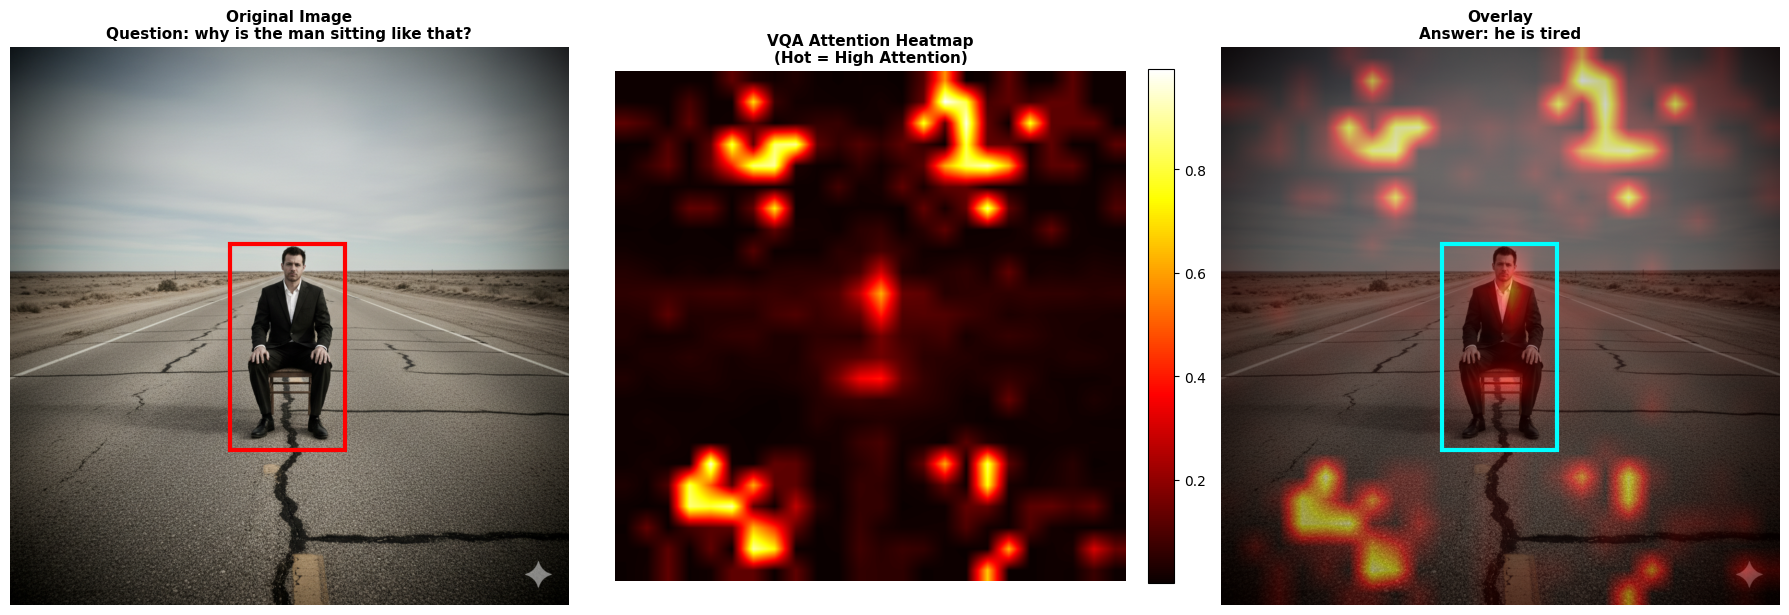

In [7]:
# Test on a single image
print("="*60)
print("Testing VQA Attention Extraction")
print("="*60)

# Test on img_001 from Domain_1
domain = "Domain_1_Images"
img_name = "img_001.png"
img_path = Path(domain) / img_name

# Load annotation
ann_data = load_image_annotation(domain, img_name)

if ann_data and len(ann_data.get('annotations', [])) > 0:
    bbox = ann_data['annotations'][0]
    question = bbox['attributes'].get('question', '')
    curiosity_score = bbox['attributes'].get('curiosity_score', 0)
    
    print(f"\nImage: {img_name}")
    print(f"Question: {question}")
    print(f"Curiosity Score: {curiosity_score}/5")
    print(f"Extracting attention...")
    
    # Extract attention
    attention_map, answer = extract_vqa_attention(
        str(img_path), 
        question, 
        vqa_model, 
        processor, 
        device=device,
        method='cross_attention'
    )
    
    print(f"Answer: {answer}")
    print(f"Attention map shape: {attention_map.shape}")
    print(f"Attention range: [{attention_map.min():.3f}, {attention_map.max():.3f}]")
    
    # Visualize
    visualize_vqa_attention(
        str(img_path),
        question,
        attention_map,
        answer,
        bbox={'xtl': bbox['xtl'], 'ytl': bbox['ytl'], 
              'xbr': bbox['xbr'], 'ybr': bbox['ybr']}
    )
else:
    print(f"Could not load annotation for {img_name}")



Testing Attention Aggregation

Image: img_003.png
Number of questions: 3
  Q1: why is it lying there?
  Q2: why is it lying there?
  Q3: why is the person ironing there?

Aggregated attention shape: (1024, 1024)


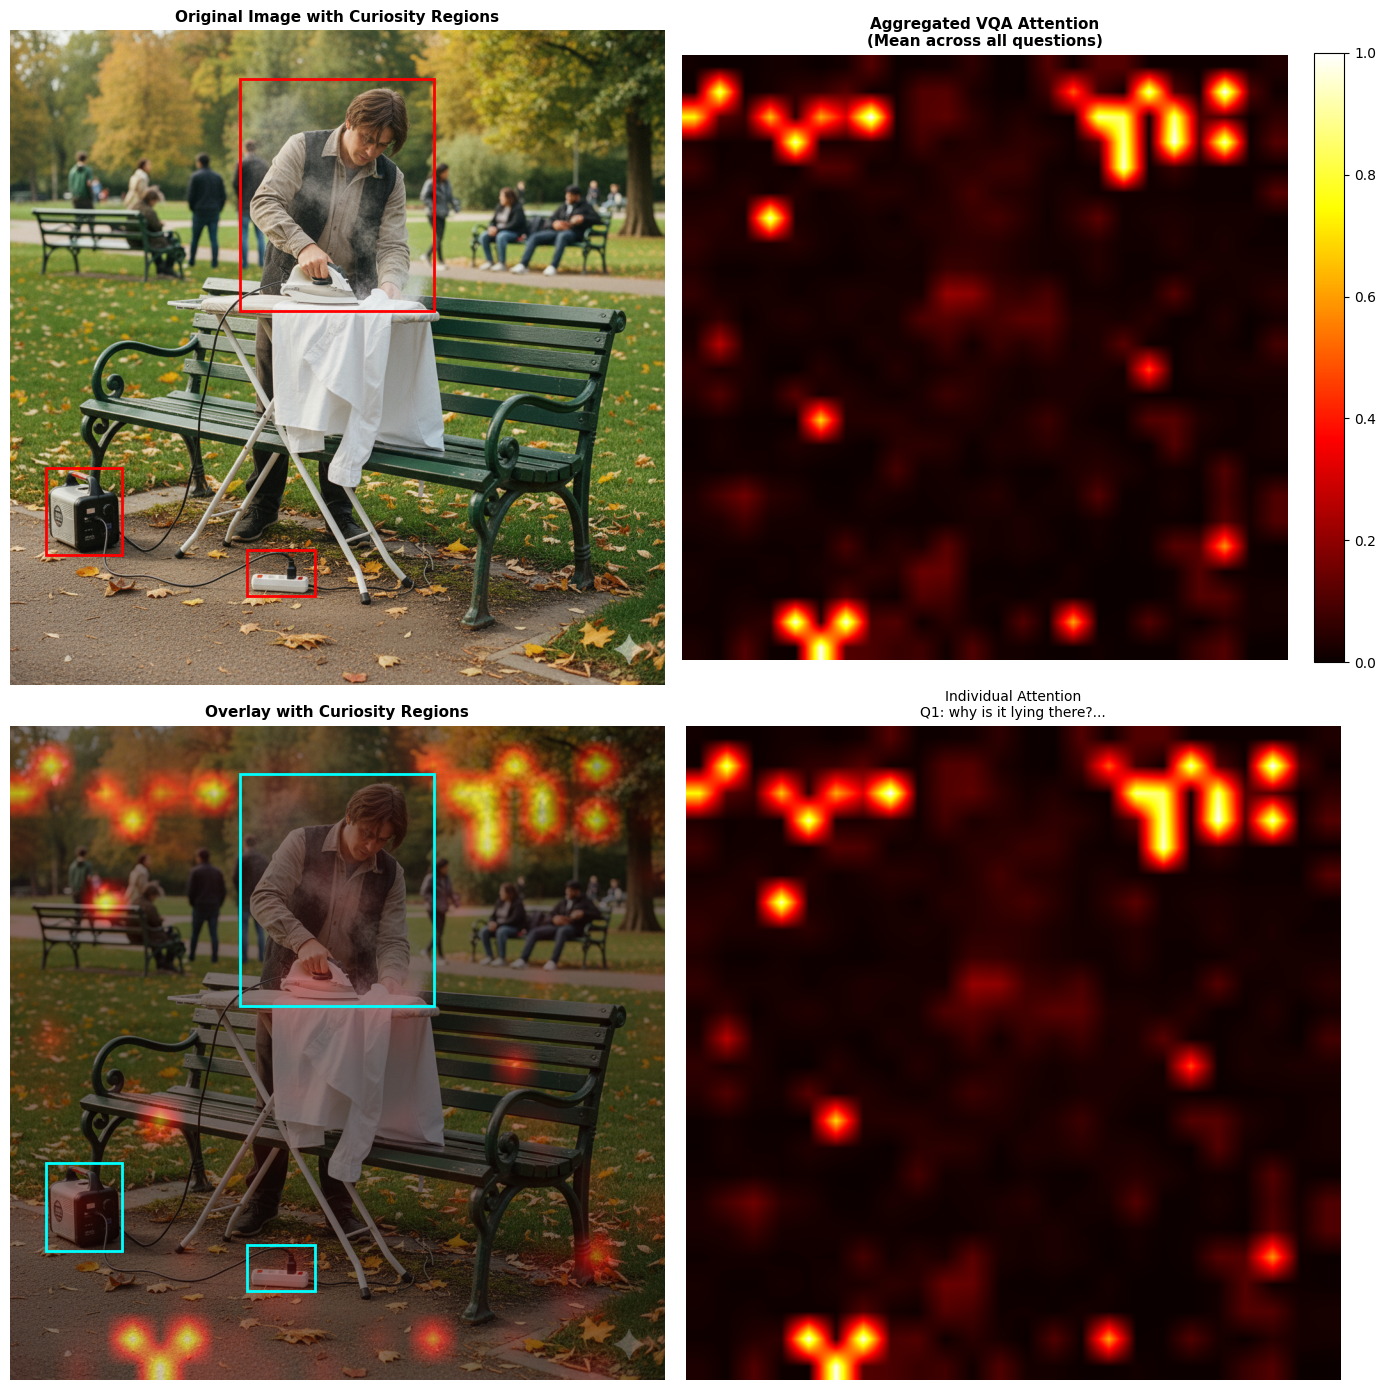


Answers:
  Q1: why is it lying there?
  A1: it is being thrown away

  Q2: why is it lying there?
  A2: it is being thrown away

  Q3: why is the person ironing there?
  A3: to get more customers



In [8]:
# Aggregate attention from multiple questions
def aggregate_vqa_attention(image_path, questions_list, model, processor, device='cuda', 
                           aggregation='mean'):
    """
    Aggregate attention from multiple questions to find question-relevant regions
    
    Args:
        image_path: Path to image
        questions_list: List of question strings
        model: VQA model
        processor: Processor
        device: Device
        aggregation: 'mean' or 'max'
    
    Returns:
        aggregated_attention: 2D numpy array
        individual_maps: List of individual attention maps
    """
    individual_maps = []
    answers = []
    
    for question in questions_list:
        attention_map, answer = extract_vqa_attention(
            image_path, question, model, processor, device
        )
        individual_maps.append(attention_map)
        answers.append(answer)
    
    # Aggregate
    if aggregation == 'mean':
        aggregated = np.mean(individual_maps, axis=0)
    elif aggregation == 'max':
        aggregated = np.max(individual_maps, axis=0)
    else:
        raise ValueError(f"Unknown aggregation: {aggregation}")
    
    # Normalize
    aggregated = (aggregated - aggregated.min()) / (aggregated.max() - aggregated.min() + 1e-8)
    
    return aggregated, individual_maps, answers

# Test aggregation on an image with multiple questions
print("\n" + "="*60)
print("Testing Attention Aggregation")
print("="*60)

# Load all annotations for img_003 (has multiple curiosity regions)
domain = "Domain_1_Images"
img_name = "img_003.png"
img_path = Path(domain) / img_name

ann_data = load_image_annotation(domain, img_name)

if ann_data and len(ann_data.get('annotations', [])) > 0:
    # Get all questions for this image
    questions = [bbox['attributes'].get('question', '') 
                 for bbox in ann_data['annotations'] 
                 if bbox['attributes'].get('question', '').strip()]
    
    print(f"\nImage: {img_name}")
    print(f"Number of questions: {len(questions)}")
    for i, q in enumerate(questions, 1):
        print(f"  Q{i}: {q}")
    
    # Aggregate attention
    aggregated_attn, individual_maps, answers = aggregate_vqa_attention(
        str(img_path), questions, vqa_model, processor, device, aggregation='mean'
    )
    
    print(f"\nAggregated attention shape: {aggregated_attn.shape}")
    
    # Visualize aggregated attention
    image = Image.open(img_path).convert('RGB')
    img_array = np.array(image)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    
    # Original image
    axes[0, 0].imshow(img_array)
    # Draw all bounding boxes
    for bbox in ann_data['annotations']:
        xtl, ytl = int(bbox['xtl']), int(bbox['ytl'])
        xbr, ybr = int(bbox['xbr']), int(bbox['ybr'])
        rect = plt.Rectangle((xtl, ytl), xbr-xtl, ybr-ytl, 
                           fill=False, edgecolor='red', linewidth=2)
        axes[0, 0].add_patch(rect)
    axes[0, 0].set_title("Original Image with Curiosity Regions", fontsize=11, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Aggregated attention
    im1 = axes[0, 1].imshow(aggregated_attn, cmap='hot', interpolation='bilinear')
    axes[0, 1].set_title("Aggregated VQA Attention\n(Mean across all questions)", 
                        fontsize=11, fontweight='bold')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    # Overlay
    axes[1, 0].imshow(img_array)
    axes[1, 0].imshow(aggregated_attn, cmap='hot', alpha=0.5, interpolation='bilinear')
    for bbox in ann_data['annotations']:
        xtl, ytl = int(bbox['xtl']), int(bbox['ytl'])
        xbr, ybr = int(bbox['xbr']), int(bbox['ybr'])
        rect = plt.Rectangle((xtl, ytl), xbr-xtl, ybr-ytl, 
                           fill=False, edgecolor='cyan', linewidth=2)
        axes[1, 0].add_patch(rect)
    axes[1, 0].set_title("Overlay with Curiosity Regions", fontsize=11, fontweight='bold')
    axes[1, 0].axis('off')
    
    # Show individual attention maps
    if len(individual_maps) > 0:
        axes[1, 1].imshow(individual_maps[0], cmap='hot', interpolation='bilinear')
        axes[1, 1].set_title(f"Individual Attention\nQ1: {questions[0][:40]}...", 
                            fontsize=10)
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print answers
    print("\nAnswers:")
    for i, (q, a) in enumerate(zip(questions, answers), 1):
        print(f"  Q{i}: {q}")
        print(f"  A{i}: {a}")
        print()
else:
    print(f"Could not load annotation for {img_name}")


In [9]:
# Combine VQA attention with existing curiosity heatmaps
def combine_curiosity_heatmaps(gaussian_heatmap, saliency_heatmap, vqa_attention_map,
                               weights={'gaussian': 0.4, 'saliency': 0.3, 'vqa': 0.3}):
    """
    Combine Gaussian curiosity, saliency, and VQA attention into hybrid heatmap
    
    Args:
        gaussian_heatmap: Gaussian-based curiosity heatmap (from your annotations)
        saliency_heatmap: Saliency-based heatmap
        vqa_attention_map: VQA attention heatmap
        weights: Dictionary of weights for each component
    
    Returns:
        hybrid_heatmap: Combined heatmap
    """
    # Ensure all maps are same size
    target_shape = gaussian_heatmap.shape
    
    if saliency_heatmap.shape != target_shape:
        saliency_heatmap = cv2.resize(saliency_heatmap, 
                                     (target_shape[1], target_shape[0]), 
                                     interpolation=cv2.INTER_LINEAR)
    
    if vqa_attention_map.shape != target_shape:
        vqa_attention_map = cv2.resize(vqa_attention_map, 
                                       (target_shape[1], target_shape[0]), 
                                       interpolation=cv2.INTER_LINEAR)
    
    # Normalize all maps to [0, 1]
    def normalize_map(m):
        m_min, m_max = m.min(), m.max()
        if m_max - m_min > 1e-8:
            return (m - m_min) / (m_max - m_min)
        return m
    
    gaussian_norm = normalize_map(gaussian_heatmap)
    saliency_norm = normalize_map(saliency_heatmap)
    vqa_norm = normalize_map(vqa_attention_map)
    
    # Weighted combination
    hybrid = (weights['gaussian'] * gaussian_norm + 
              weights['saliency'] * saliency_norm + 
              weights['vqa'] * vqa_norm)
    
    # Normalize result
    hybrid = normalize_map(hybrid)
    
    return hybrid, {
        'gaussian': gaussian_norm,
        'saliency': saliency_norm,
        'vqa': vqa_norm
    }

print("Heatmap combination function ready")


Heatmap combination function ready


Combining VQA Attention with Curiosity Heatmaps


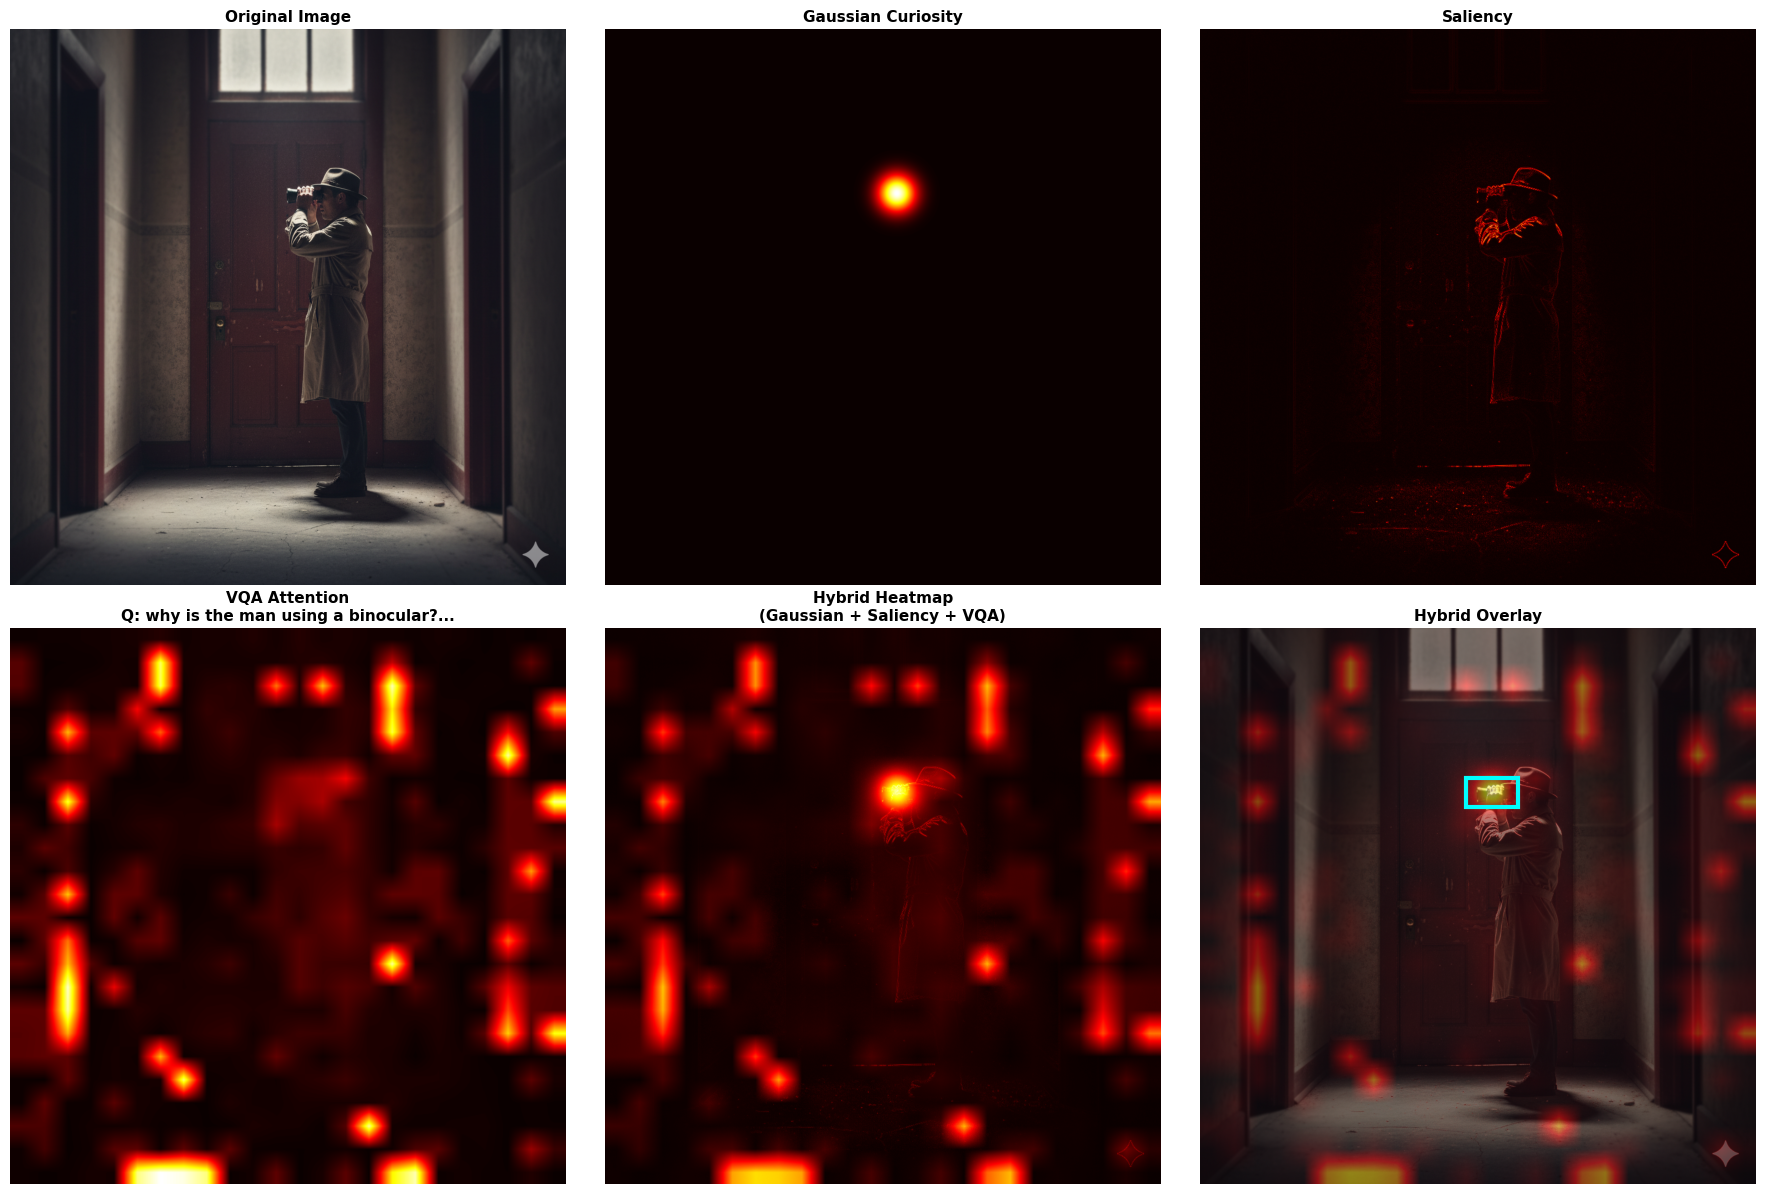

Hybrid heatmap created
  Question: why is the man using a binocular?
  Answer: to see


In [10]:
# Example: Combine VQA attention with existing heatmaps
# Note: This requires your existing heatmap generation functions
# For demonstration, we'll create simple Gaussian and saliency maps

print("="*60)
print("Combining VQA Attention with Curiosity Heatmaps")
print("="*60)

# Load a test image
domain = "Domain_1_Images"
img_name = "img_020.png"
img_path = Path(domain) / img_name
ann_data = load_image_annotation(domain, img_name)

if ann_data and len(ann_data.get('annotations', [])) > 0:
    bbox = ann_data['annotations'][0]
    question = bbox['attributes'].get('question', '')
    
    # Get VQA attention
    vqa_attention, answer = extract_vqa_attention(
        str(img_path), question, vqa_model, processor, device
    )
    
    # Create simple Gaussian heatmap (simplified version)
    # In practice, use your existing generate_gaussian_heatmap function
    image = Image.open(img_path).convert('RGB')
    img_array = np.array(image)
    h, w = img_array.shape[:2]
    
    # Simple Gaussian centered on bbox
    xtl, ytl = int(bbox['xtl']), int(bbox['ytl'])
    xbr, ybr = int(bbox['xbr']), int(bbox['ybr'])
    center_x, center_y = (xtl + xbr) / 2, (ytl + ybr) / 2
    
    y_coords, x_coords = np.ogrid[:h, :w]
    gaussian_heatmap = np.exp(-((x_coords - center_x)**2 + (y_coords - center_y)**2) / (2 * ((xbr-xtl)/4)**2))
    gaussian_heatmap = (gaussian_heatmap - gaussian_heatmap.min()) / (gaussian_heatmap.max() - gaussian_heatmap.min())
    
    # Simple saliency (using grayscale variance as proxy)
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    saliency_heatmap = cv2.Laplacian(gray, cv2.CV_64F)
    saliency_heatmap = np.abs(saliency_heatmap)
    saliency_heatmap = (saliency_heatmap - saliency_heatmap.min()) / (saliency_heatmap.max() - saliency_heatmap.min())
    
    # Combine
    hybrid, components = combine_curiosity_heatmaps(
        gaussian_heatmap, saliency_heatmap, vqa_attention,
        weights={'gaussian': 0.4, 'saliency': 0.2, 'vqa': 0.4}
    )
    
    # Visualize
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Individual components
    axes[0, 0].imshow(img_array)
    axes[0, 0].set_title("Original Image", fontsize=11, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(components['gaussian'], cmap='hot')
    axes[0, 1].set_title("Gaussian Curiosity", fontsize=11, fontweight='bold')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(components['saliency'], cmap='hot')
    axes[0, 2].set_title("Saliency", fontsize=11, fontweight='bold')
    axes[0, 2].axis('off')
    
    # Row 2: VQA and Hybrid
    axes[1, 0].imshow(components['vqa'], cmap='hot')
    axes[1, 0].set_title(f"VQA Attention\nQ: {question[:50]}...", fontsize=11, fontweight='bold')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(hybrid, cmap='hot')
    axes[1, 1].set_title("Hybrid Heatmap\n(Gaussian + Saliency + VQA)", fontsize=11, fontweight='bold')
    axes[1, 1].axis('off')
    
    # Overlay
    axes[1, 2].imshow(img_array)
    axes[1, 2].imshow(hybrid, cmap='hot', alpha=0.5, interpolation='bilinear')
    rect = plt.Rectangle((xtl, ytl), xbr-xtl, ybr-ytl, 
                       fill=False, edgecolor='cyan', linewidth=3)
    axes[1, 2].add_patch(rect)
    axes[1, 2].set_title("Hybrid Overlay", fontsize=11, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Hybrid heatmap created")
    print(f"  Question: {question}")
    print(f"  Answer: {answer}")
else:
    print(f"Could not load annotation for {img_name}")
